In [27]:
import torch
import einops

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import itertools

from utils.components import *
from utils.config import *
from utils.einmask import EinMask
from utils.dataset import NinoData

from utils.masking import *

from omegaconf import OmegaConf
from dataclasses import replace

import torch_harmonics

In [37]:
ds = xr.open_zarr("./runs/2259352/piControl_eval.zarr")

FileNotFoundError: No such file or directory: '/mnt/lustre/work/ludwig/jthuemmel54/thesis/runs/2259352/piControl_eval.zarr'

In [29]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:           (ens: 8, lag: 24, lat: 41, lon: 91, time: 448)
Coordinates:
  * ens               (ens) int64 64B 0 1 2 3 4 5 6 7
  * lag               (lag) int64 192B 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24
  * lat               (lat) float64 328B -20.0 -19.0 -18.0 ... 18.0 19.0 20.0
  * lon               (lon) float64 728B 90.0 92.0 94.0 ... 266.0 268.0 270.0
    month             (time) int64 4kB ...
  * time              (time) datetime64[ns] 4kB 1980-01-01 ... 2017-04-01
    variable          <U12 48B ...
Data variables:
    temp_ocn_0a_pred  (time, lag, lat, lon, ens) float64 3GB ...
    temp_ocn_0a_tgt   (time, lag, lat, lon) float64 321MB ...

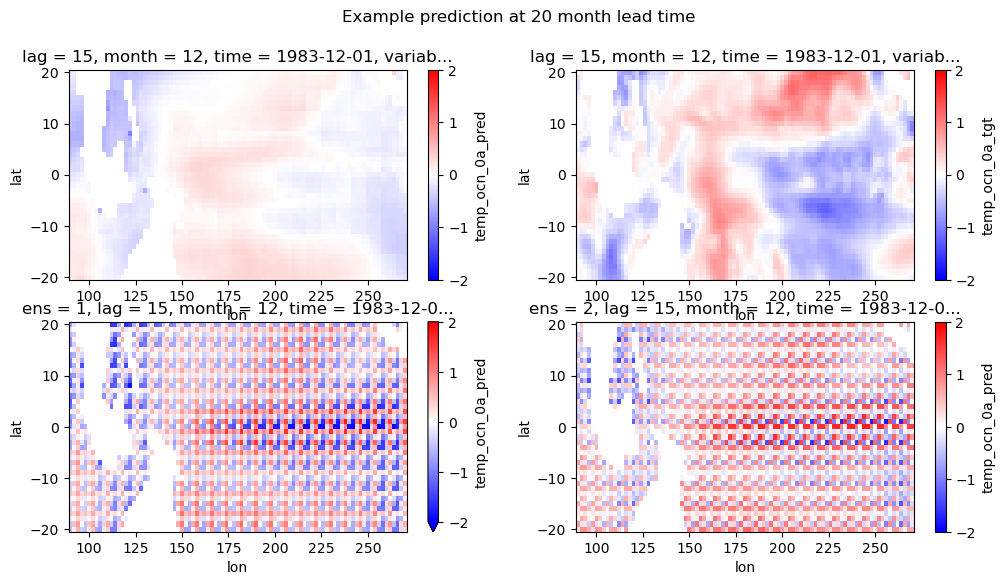

In [30]:
plt.figure(figsize=(12,6))
tau = 15
plt.subplot(221)
ds['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau).mean("ens").plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.subplot(222)
ds['temp_ocn_0a_tgt'].sel(time="1983-12-01", lag=tau).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.suptitle("Example prediction at 20 month lead time")
plt.subplot(223)
ds['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau, ens=1).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.subplot(224)
ds['temp_ocn_0a_pred'].sel(time="1983-12-01", lag=tau, ens=2).plot(vmin=-2, vmax = 2, cmap= 'bwr')

In [31]:
import math

def get_field_metrics(eval_data: xr.Dataset):
    for var in ["temp_ocn_0a"]:
        tgt, pred = eval_data[f"{var}_tgt"], eval_data[f'{var}_pred']
        pcc = xr_pcc(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        rmse = xr_rmse(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        ssr = xr_spread_skill(pred, tgt, ('lat', 'lon')).mean(('time'))
        
    return {
        "pcc": pcc, "rmse": rmse, "ssr": ssr
    }

def get_nino_metrics( eval_data: xr.Dataset):
    nino34_tgt, nino34_pred = get_nino34(eval_data["temp_ocn_0a_tgt"]), get_nino34(eval_data["temp_ocn_0a_pred"]).mean("ens")
    nino4_tgt, nino4_pred = get_nino4(eval_data["temp_ocn_0a_tgt"]), get_nino4(eval_data["temp_ocn_0a_pred"]).mean("ens")
    
    nino34_pcc = xr_pcc(nino34_pred, nino34_tgt, ("time",))
    nino4_pcc = xr_pcc(nino4_pred, nino4_tgt, ("time",))

    nino34_rmse = xr_rmse(nino34_pred, nino34_tgt, ("time",))
    nino4_rmse = xr_rmse(nino4_pred, nino4_tgt, ("time",))

    nino4_thresh_month =  1 + np.argwhere(nino4_pcc.values > 0.5).max(initial=0)
    nino34_thresh_month = 1 + np.argwhere(nino34_pcc.values > 0.5).max(initial=0)

    nino4_ssr = xr_spread_skill(get_nino4(eval_data["temp_ocn_0a_pred"]), nino4_tgt, ("time",))
    nino34_ssr = xr_spread_skill(get_nino34(eval_data["temp_ocn_0a_pred"]), nino34_tgt, ("time",))

    return {
        "nino34_pcc": nino34_pcc, "nino4_pcc": nino4_pcc,
        "nino34_rmse": nino34_rmse, "nino4_rmse": nino4_rmse,
        "nino34_thresh_month": nino34_thresh_month,
        "nino4_thresh_month": nino4_thresh_month,
        "nino34_ssr": nino34_ssr, "nino4_ssr": nino4_ssr
    }
    

@staticmethod
def get_nino4(da: xr.DataArray):
    return da.sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

@staticmethod
def get_nino34(da: xr.DataArray):
    return da.sel(lon=slice(190, 240), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

@staticmethod
def xr_pcc(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    num = (pred * obs).sum(dim)
    denom = np.sqrt((pred**2).sum(dim)) * np.sqrt((obs**2).sum(dim))
    return num / denom

@staticmethod
def xr_rmse(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    return np.sqrt(((pred - obs) ** 2).mean(dim))

@staticmethod
def xr_spread_skill(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    K = pred.sizes["ens"]
    correction = math.sqrt((K + 1) / K)
    mean = pred.mean("ens")
    spread = np.sqrt(pred.var("ens").mean(dim))
    skill = np.sqrt(((obs - mean) ** 2).mean(dim))
    return correction * (spread / skill)


In [32]:
field_metrics = get_field_metrics(ds)
nino_metrics = get_nino_metrics(ds)

Text(0.5, 0.98, 'PiControl all metrics')

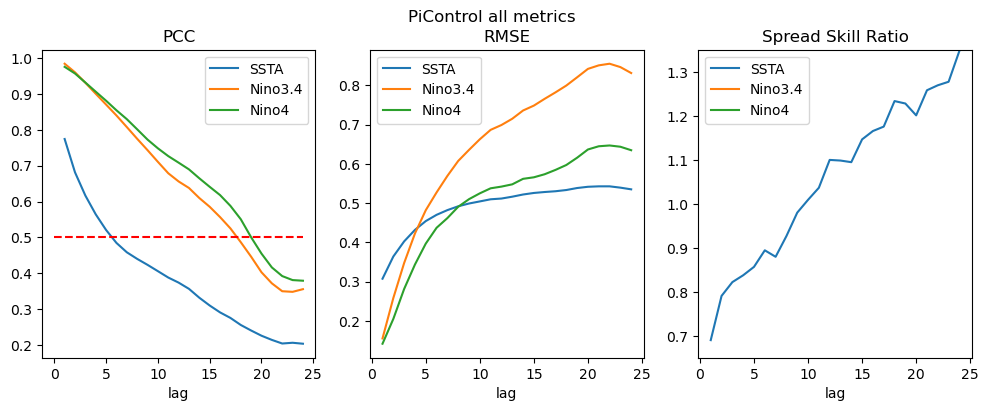

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(131)
field_metrics["pcc"].plot()
nino_metrics["nino34_pcc"].plot()
nino_metrics["nino4_pcc"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.title("PCC")
plt.subplot(132)
field_metrics["rmse"].plot()
nino_metrics["nino34_rmse"].plot()
nino_metrics["nino4_rmse"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.title("RMSE")
plt.subplot(133)
field_metrics["ssr"].plot()
nino_metrics["nino34_ssr"].plot()
nino_metrics["nino4_ssr"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.ylim(0.65, 1.35)
plt.title("Spread Skill Ratio")
plt.suptitle('PiControl all metrics')

In [34]:
geoformer_acc_nino4 = [0.994,0.963,0.931,0.9,0.87,0.843,0.816,0.789,0.768,0.748,0.732,0.718,0.703,0.677,0.652,0.624,0.592,0.557,0.512,0.455]
geoformer_rmse_nino4 = [0.104,0.167,0.23,0.295,0.339,0.38,0.41,0.427,0.445,0.459,0.467,0.481,0.504,0.527,0.537,0.553,0.592,0.622,0.637,0.672]

nino4_acc_values_old = [
    0.97918123, 0.9797946, 0.97350585, 0.9630004, 0.9482865, 0.93100137,
    0.90889394, 0.88256884, 0.85208493, 0.8207785, 0.78600186, 0.7495376,
    0.712273, 0.67880523, 0.64771086, 0.6198993, 0.58979565, 0.55733985,
    0.49893567, 0.46987474, 0.4426261, 0.4137368, 0.38565788, 0.35940564
]

nino4_rmse_values_old = [
    0.20122607, 0.19745673, 0.22672589, 0.2686358, 0.31706777, 0.36480904,
    0.41812035, 0.4719005, 0.52526784, 0.5734762, 0.6208628, 0.6637392,
    0.7021196, 0.7344313, 0.7619488, 0.7846967, 0.8073986, 0.8298172,
    0.8659962, 0.8820192, 0.8962772, 0.9108972, 0.9243836, 0.93663627
]

Text(0.5, 0.98, 'Nino4 Metric Comparison on PiControl')

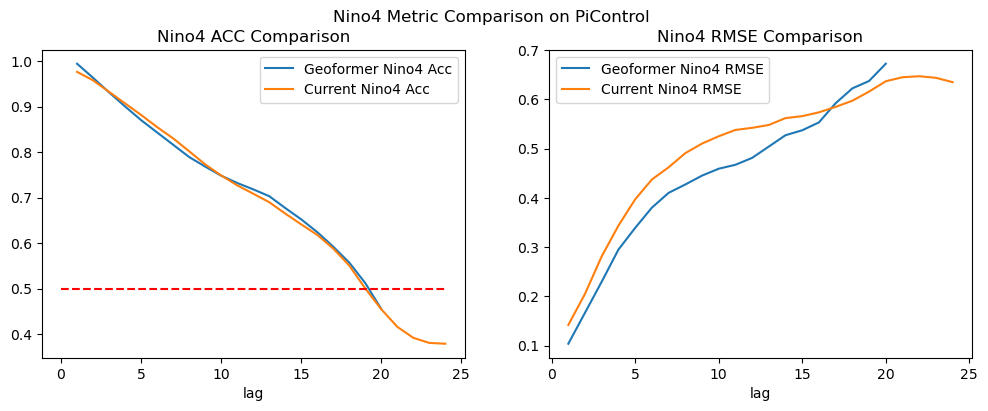

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1), geoformer_acc_nino4, label='Geoformer Nino4 Acc')
nino_metrics["nino4_pcc"].plot(label='Current Nino4 Acc')
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.legend()
plt.title("Nino4 ACC Comparison")
plt.subplot(122)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1),geoformer_rmse_nino4, label='Geoformer Nino4 RMSE')
nino_metrics["nino4_rmse"].plot(label='Current Nino4 RMSE')
plt.legend()
plt.title("Nino4 RMSE Comparison")
plt.suptitle("Nino4 Metric Comparison on PiControl")